## In this notebook, Simulation 2D fringe pattern is being explored

### Written by: Zhiyuan Guo
### Last updated by: Zhiyuan Guo on 1/7/2021
### - Update notes: 
#### 6/24/2020 - Started the project 
#### 1/7/2021 - bandwidth included full wavelength (860-990nm) simulation generated

In [1]:
from mpl_toolkits import mplot3d
from tqdm import tqdm

In [2]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate
import astropy.table
from astropy.io import fits
import astropy.units as u
import csv
import pandas as pd
import tmm
from Getindex import load_refraction_data
import lsst.afw.display as afwDisplay
from lsst.ip.isr import IsrTask
import lsst.afw.math as afwMath
import lsst.afw.image as afwImage

Populating the interactive namespace from numpy and matplotlib


In [3]:
index_of_refraction = load_refraction_data(Epoxy_ind=1.6,Temp = 183.)

In [4]:
def generate_heightfield(fractal_dimension=2.5, n=100, seed=123):

    H = 1 - (fractal_dimension - 2)
    kpow = -(H + 1.0) / 2.0
    
    A = np.zeros((n, n), complex)

    kvec = np.fft.fftfreq(n)
    k0 = kvec[n // 64]
    kx, ky = np.meshgrid(kvec, kvec, sparse=True, copy=False)
    ksq = kx ** 2 + ky ** 2
    m = ksq > 0

    gen = np.random.RandomState(seed=seed)    
    phase = 2 * np.pi * gen.uniform(size=(n, n))
    A[m] = ksq[m] ** kpow * gen.normal(size=(n, n))[m] * np.exp(1.j * phase[m]) * np.exp(-ksq[m] / k0 ** 2)
    #print(A.shape)
    
    return np.fft.ifft2(A)


In [5]:
def E2V_model(d_si,d_si2,wlen = 800):
    material = ('Vacuum', 'MgF2','Ta2O5', 'Si_Temp', 'SiO2', 'Si_Temp', 'SiO2','Epoxy','Si_Temp','Si3N4')
    thickness_um = (np.inf, 0.1221,0.0441,100., 0.1, 0.3,1.,14.8+d_si2,130-d_si2, np.inf)

    # Assume normal incidence.
    theta = 0.

    # Define the wavelengths to calculate, matching the coverage of Figs. 3 and 4.
    #wlen_um = 1e-3 * wlen

    n_list = [index_of_refraction[m](wlen) for m in material]
    R = T = 0
    for pol in 'sp':

        # Using tmm package to do multilayer thin-film simulation
        result = tmm.coh_tmm(pol, n_list, thickness_um, theta, 1e-3 * wlen)
        # Store R and T results
        R += 0.5*result['R']
        T += 0.5*result['T']

    A = 1 - R - T

    return(A)

In [6]:
# Define some function for plotting, adjusting the z-scale.

def cmap_range(image_array, nsig=3):
    pixel_data = np.array(image_array, dtype=np.float).flatten()
    stats = afwMath.makeStatistics(pixel_data,
                                   afwMath.STDEVCLIP | afwMath.MEDIAN)
    median = stats.getValue(afwMath.MEDIAN)
    stdev = stats.getValue(afwMath.STDEVCLIP)
    vmin = max(min(pixel_data), median - nsig*stdev)
    vmax = min(max(pixel_data), median + nsig*stdev)
    return vmin, vmax

def im_show (data):
    #plt.figure(figsize = (9,9))
    vmin, vmax = cmap_range(data)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    plt.imshow(data,origin='lower',norm=norm,cmap = pylab.cm.hot)
    cb = plt.colorbar()
    cb.remove()
    plt.axis('off');

In [40]:
x = range(100)
y = range(100)
X, Y = np.meshgrid(x, y)

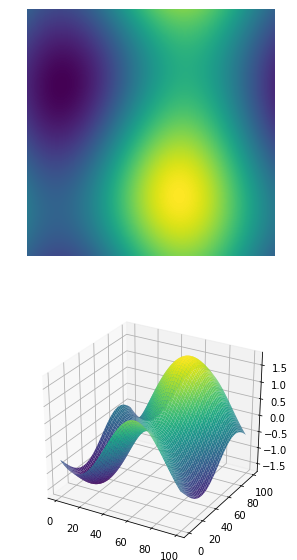

In [91]:
height_f2 = generate_heightfield(fractal_dimension= 0.8,n=100,seed = 7).real
hf = plt.figure(figsize = (5,10))
scale_factor2 = 1.8/np.max(height_f2)
h2d = hf.add_subplot(211)
h2d.imshow(height_f2,interpolation='bicubic')
h2d.axis('off')
#cb = plt.colorbar()
#cb.set_label(label='Thickness (um)', size='large', weight='bold')
ha = hf.add_subplot(212, projection='3d')

ha.plot_surface(X, Y, height_f2*scale_factor2,cmap='viridis');

In [92]:
np.max(height_f2*scale_factor2),np.min(height_f2*scale_factor2)

(1.8, -1.681681820734339)

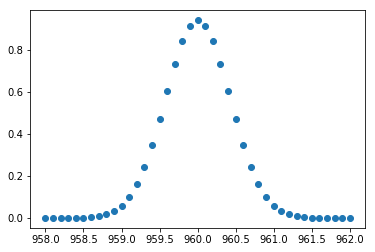

In [33]:
# Define the gaussian function
def gaussian(x, mu, FWHM):

    # Calculate sigma based on FWHM value 2nm
    # FWHM = 2*sqrt(2*ln2)*sigma

    sig = FWHM/(2*np.sqrt(2*np.log(2)))

    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-((x - mu)/sig)**2/2)

avg_wlen_width = 1
window =40

cen_wav = 960
x = np.linspace(cen_wav-2*avg_wlen_width,cen_wav+2*avg_wlen_width,window+1)

# Assign weight to each point based on the gaussian
weight = gaussian(x,cen_wav,avg_wlen_width)
plt.plot(x,weight,'o')

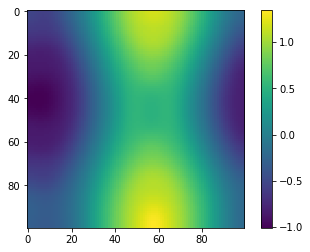

In [13]:
hdu = fits.open('ML/Predict_data.fits')
predict = hdu[1].data['Prediction']
predict = predict.reshape(100,100)
plt.imshow(14.8-predict)
plt.colorbar()

In [82]:
Fringe_map = np.zeros_like(height_f2)


for i in range(len(height_f2)):
    for j in range(len(height_f2)):
        Fringe_map[i,j]= E2V_model(d_si = 0,d_si2= height_f2[i,j]*scale_factor2,wlen=960)

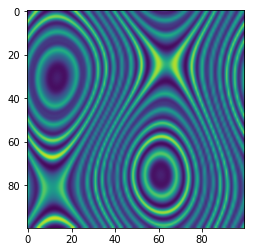

In [83]:
plt.figure(figsize = (4,4))
imshow(Fringe_map,interpolation='bicubic')

In [86]:
Fringe_map = np.zeros_like(height_f2)

avg_wlen_width = 2
window =40

cen_wav = 960
x = np.linspace(cen_wav-2*avg_wlen_width,cen_wav+2*avg_wlen_width,window+1)

# Assign weight to each point based on the gaussian

weight = gaussian(x,cen_wav,avg_wlen_width)
for k in tqdm(range(len(x))):
    for i in range(len(height_f2)):
        for j in range(len(height_f2)):
            Fringe_map[i,j]+= weight[k]*E2V_model(d_si = 0,d_si2= height_f2[i,j]*scale_factor2,wlen=x[k])
Fringe_map = Fringe_map/np.sum(weight)


100%|██████████| 41/41 [06:01<00:00,  8.82s/it]


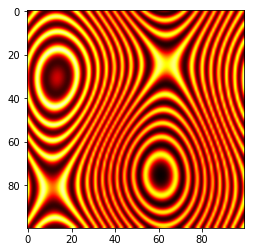

In [87]:
plt.imshow(Fringe_map,interpolation='bicubic',cmap = pylab.cm.hot)

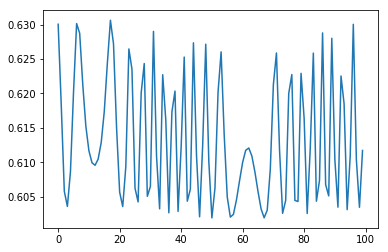

In [88]:
plt.plot(Fringe_map[50,:])

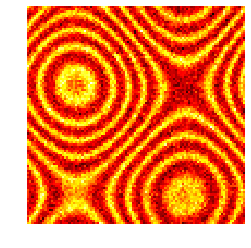

In [14]:
a = (np.max(Fringe_map[80,:])+np.min(Fringe_map[80,:]))/2
A = (Fringe_map)/a-1


mu, sigma = 20000, np.sqrt(20000) # mean and standard deviation
s = np.random.normal(mu, sigma, (100,100))
sim_data = sim_data = (A + 1) * 20000
sim_data = sim_data + s - 20000
im_show(sim_data)

In [29]:
wlens = np.arange(890,1000,10)

In [30]:
wlens

array([890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990])

In [93]:
data = {}
for m in range(len(wlens)):
    
    avg_wlen_width = 2
    window =40

    cen_wav = wlens[m]
    x = np.linspace(cen_wav-2*avg_wlen_width,cen_wav+2*avg_wlen_width,window+1)

    # Assign weight to each point based on the gaussian
    weight = gaussian(x,cen_wav,avg_wlen_width)

    Fringe_map = np.zeros_like(height_f2)
    for k in tqdm(range(len(x))):
        for i in range(len(height_f2)):
            for j in range(len(height_f2)):
                Fringe_map[i,j]+= weight[k]*E2V_model(d_si = 0,d_si2= height_f2[i,j]*scale_factor2,wlen=x[k])
    Fringe_map = Fringe_map/np.sum(weight)       
    data[(m)] = Fringe_map

100%|██████████| 41/41 [06:32<00:00,  9.58s/it]


In [98]:

col1 = fits.Column(name='Sim', format='110000D', dim='(100,100)', array=data2)
#col2 = fits.Column(name='doublearray', format='120000D', dim='(100,100)', array=data2)

In [100]:
values = np.arange(2*2*4).reshape(4, 2, 2)
values.shape

(4, 2, 2)

In [100]:
wlens

array([890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990])

In [101]:
hdr = fits.Header()
hdr['Creator'] = 'Zhiyuan Guo'
hdr['Date'] = '2/11/2021'
hdr['Map_Id'] = 'fractal_dimension= 0.8,n=100,seed = 7'
hdr['Bandpass'] = '2nm'
hdr['Dim'] = '100X100 pixel per wavelength'
hdr['Spacing'] = 'S:890nm , E:990nm , Step: 10nm'
hdr['Model'] = 'Vacuum MgF2 Ta2O5 Si SiO2 Si SiO2 Epoxy Si Si3N4'
hdr['Thick'] = 'np.inf, 0.1221,0.0441,100., 0.1, 0.3,1.,14.8+d_si2,130-d_si2, np.inf'
empty_primary = fits.PrimaryHDU(header=hdr)

In [102]:
hdu = fits.BinTableHDU.from_columns([col1])
hdul = fits.HDUList([empty_primary, hdu])

In [105]:

hdul.writeto('Sim_Data3.fits')

In [173]:
rm Sim_Data.fits

In [106]:
hh = fits.open('Sim_data3.fits')
hh[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                80000 / length of dimension 1                          
NAXIS2  =                   11 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    1 / number of table fields                         
TTYPE1  = 'Sim     '                                                            
TFORM1  = '110000D '                                                            
TDIM1   = '(100,100)'                                                           

In [107]:
ah = hh[1].data['Sim']
ah.shape

(11, 100, 100)

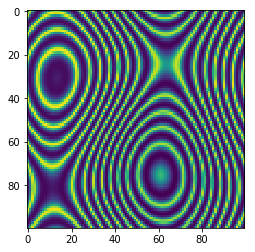

In [114]:
plt.imshow(ah[0])

In [95]:
data2 = []
for i in range(len(data)):
    data2.append(data[i])

In [96]:
data2 = np.array(data2)
data2.shape

(11, 100, 100)

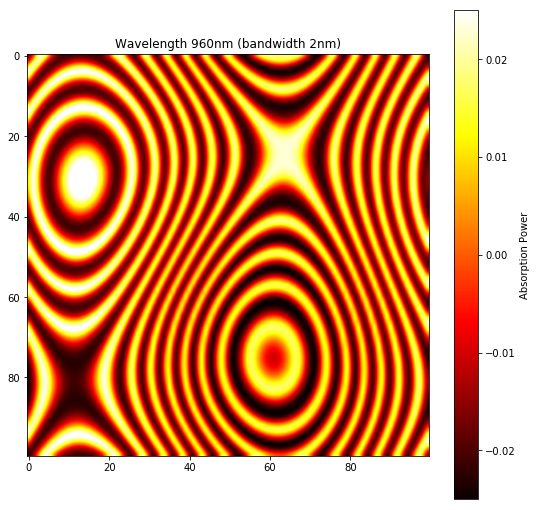

In [124]:
Fringe_map = data[10]
plt.figure(figsize = (9,9))
plt.subplot(111)
plt.title('Wavelength 960nm (bandwidth 2nm)')
a = (np.max(Fringe_map[80,:])+np.min(Fringe_map[80,:]))/2
A = (Fringe_map)/a-1
plt.imshow(A,interpolation='bicubic',cmap = pylab.cm.hot,vmin = -0.025,vmax = 0.025)
cb = plt.colorbar(label = 'Absorption Power');
#cb.remove()

plt.axis('on');

#plt.subplot(212)
#a = (np.max(Fringe_map[80,:])+np.min(Fringe_map[80,:]))/2
#A = (Fringe_map)/a-1
#plt.plot(A[60,:])
#plt.axhline(0,ls = '--',color = 'black',linewidth = 2);
#plt.ylim(-0.025,0.025)
#plt.xlabel('x pixel',fontsize = 15)
#plt.ylabel('Fringe amplitude',fontsize = 15)


#plt.grid();
#plt.close()
#plt.savefig('data/Sim/860.png')

In [199]:
cd ../..

/Users/zhiyuanguo/Documents/Research/Fringe Science/AstroCCD-master


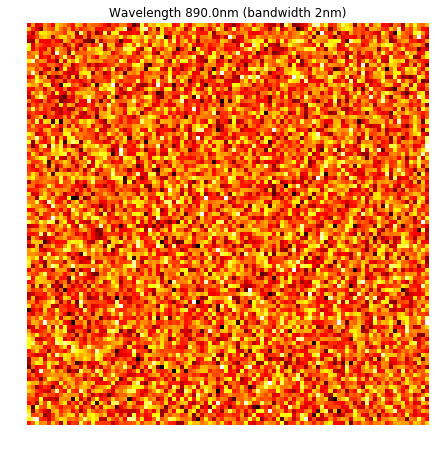

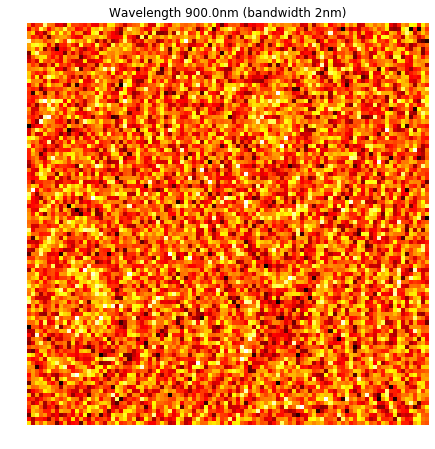

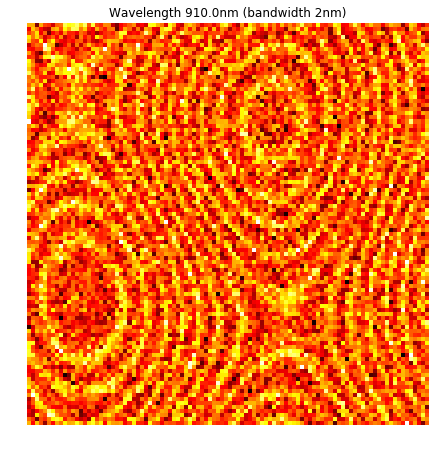

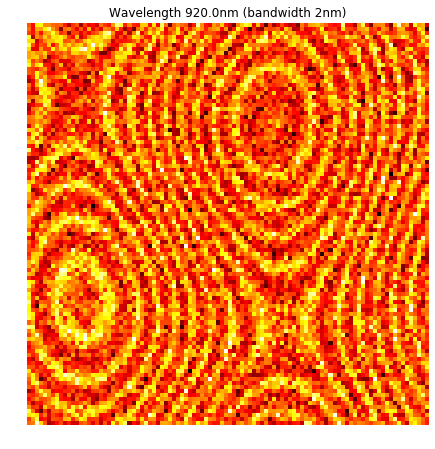

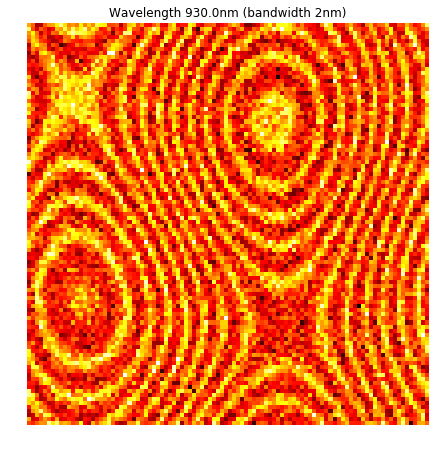

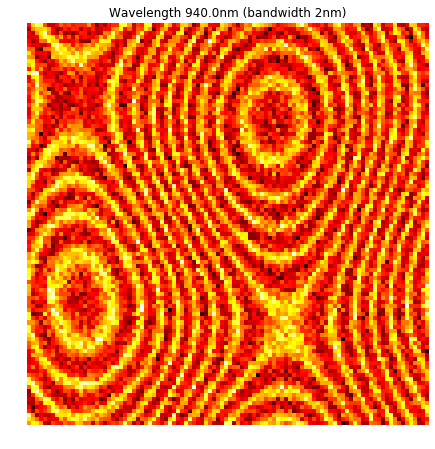

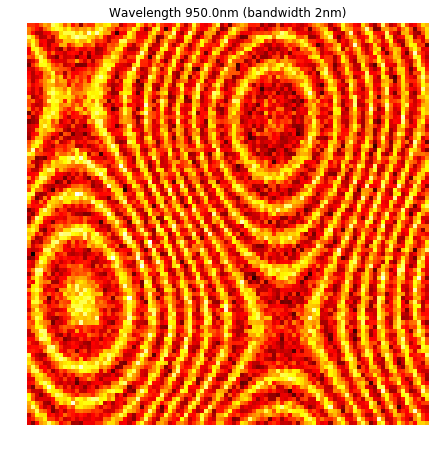

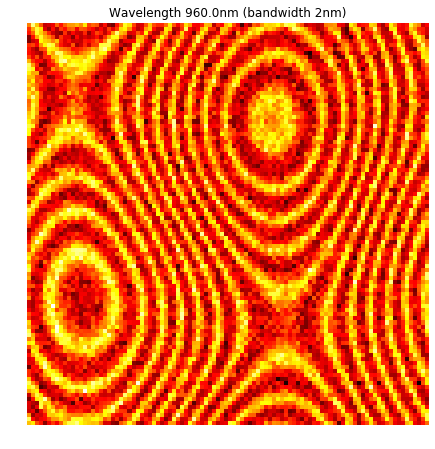

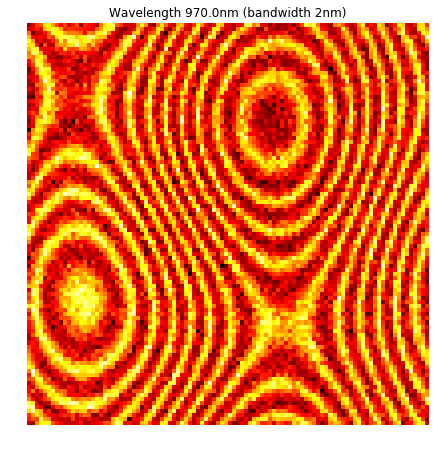

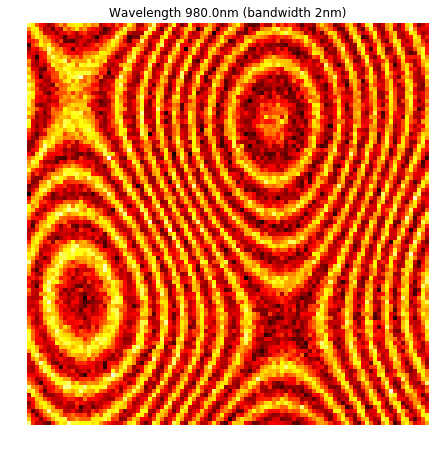

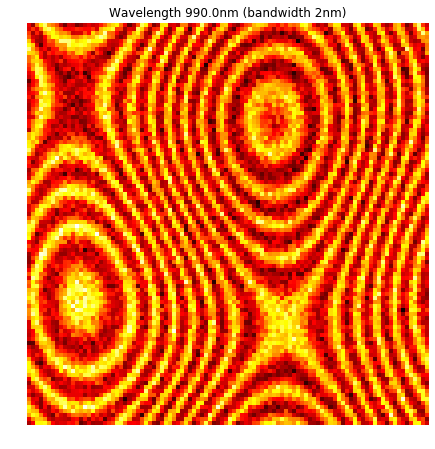

In [115]:
for i in range(len(data)):
    
    plt.figure(figsize = (9,9))
    sim_data = 0
    Fringe_map = data[i]
    
    plt.subplot(111)
    plt.title('Wavelength %.1fnm (bandwidth 2nm)'%wlens[i])
    a = (np.max(Fringe_map[80,:])+np.min(Fringe_map[80,:]))/2
    A = (Fringe_map)/a-1
    
    
    mu, sigma = 20000, np.sqrt(20000) # mean and standard deviation
    s = np.random.normal(mu, sigma, (100,100))
    sim_data = sim_data = (A + 1) * 20000
    sim_data = sim_data + s - 20000
    im_show(sim_data)
    
    filename = 'data/Sim/'+str(wlens[i])+'.png'
    plt.savefig(filename)
    #plt.close();

In [20]:
mu, sigma = 20000, np.sqrt(20000) # mean and standard deviation
s = np.random.normal(mu, sigma, (100,100))

In [26]:
s

array([[19896.08449847, 20193.36284446, 19963.34226575, ...,
        20173.80705414, 19975.80191987, 20128.90202196],
       [19988.58789827, 20171.99493134, 19927.15959285, ...,
        20305.68285   , 19959.67702118, 20087.28988834],
       [19949.71700251, 19982.90781462, 20030.81574734, ...,
        20048.33752776, 20215.93084125, 19954.81809163],
       ...,
       [20054.1078541 , 20113.72682761, 19899.78470988, ...,
        19891.93347845, 19930.85050353, 20114.81062197],
       [19904.21916961, 20171.65412324, 20031.78962419, ...,
        19781.1641748 , 20232.61526438, 20027.52104875],
       [19962.18930614, 19991.14158332, 19973.02328199, ...,
        19928.18606139, 19987.91084991, 19976.22714687]])

In [31]:
sim_data = sim_data + s - 20000

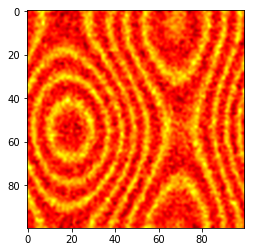

In [28]:
plt.imshow(sim_data,interpolation='bicubic',cmap = pylab.cm.hot)

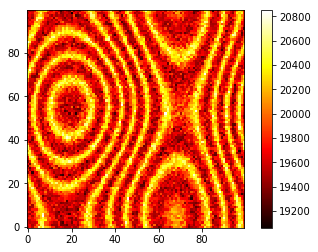

In [33]:
im_show(sim_data)

In [121]:
import os
#os.chdir('data/Sim/')
files = os.listdir()
files.sort()
if '.DS_Store' in files:
    files.remove('.DS_Store')
files

['890.png',
 '900.png',
 '910.png',
 '920.png',
 '930.png',
 '940.png',
 '950.png',
 '960.png',
 '970.png',
 '980.png',
 '990.png',
 'movie.gif']

In [122]:
import imageio
images = [imageio.imread(file) for file in files]
imageio.mimwrite('movie.gif',images,fps = 7)